
# Primeros pasos con modelos para datos meteorológicos de AEMET

En esta notebook vamos a cargar los datos limpios diarios, mensuales y anuales que tienes, y hacer una prueba sencilla con tres modelos diferentes:  
- Árbol de decisión para clasificar si hubo lluvia o no  
- Regresión lineal para predecir la cantidad de lluvia  
- Red LSTM para predecir temperatura media como serie temporal  

Vamos paso a paso, con explicaciones sencillas para que entiendas bien cada parte.

---

**Instrucciones previas:**  
Para ejecutar esta notebook necesitas tener instalado Jupyter Notebook o JupyterLab.  
Si no lo tienes, abre tu consola (cmd o PowerShell) y ejecuta:

```
pip install notebook
```

Luego, para lanzar Jupyter, navega en la consola a la carpeta donde está esta notebook y escribe:

```
jupyter notebook
```

Esto abrirá una ventana en tu navegador con la lista de archivos. Haz clic en esta notebook para abrirla y ejecutar las celdas.

---

¡Empecemos!


In [1]:

# Celda 1 - Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [3]:

# Celda 2 - Cargar datos limpios (ajusta las rutas a tus archivos)
df_diarios = pd.read_csv('src/data/limpios/AEMET/alcantarilla/diarios/diarios.csv')
df_mensuales = pd.read_csv('src/data/limpios/AEMET/alcantarilla/mensuales-anuales/mensuales.csv')
df_anuales = pd.read_csv('src/data/limpios/AEMET/alcantarilla/mensuales-anuales/anuales.csv')

print("Datos diarios cargados:", df_diarios.shape)
print("Datos mensuales cargados:", df_mensuales.shape)
print("Datos anuales cargados:", df_anuales.shape)


Datos diarios cargados: (3830, 25)
Datos mensuales cargados: (132, 44)
Datos anuales cargados: (11, 44)


In [4]:

# Celda 3 - Exploración rápida de los datos diarios
print(df_diarios.head())
print(df_diarios.info())


        fecha  indicativo                    nombre provincia  altitud  tmed  \
0  2015-01-01        7228  ALCANTARILLA, BASE AEREA    MURCIA       75   8.6   
1  2015-01-02        7228  ALCANTARILLA, BASE AEREA    MURCIA       75   8.4   
2  2015-01-03        7228  ALCANTARILLA, BASE AEREA    MURCIA       75   9.9   
3  2015-01-04        7228  ALCANTARILLA, BASE AEREA    MURCIA       75  12.2   
4  2015-01-05        7228  ALCANTARILLA, BASE AEREA    MURCIA       75   9.6   

   prec  tmin horatmin  tmax  ...  sol  presMax  horaPresMax  presMin  \
0   0.0   1.5   Varias  15.8  ...  7.3   1028.6           10   1020.8   
1   0.0  -0.4    07:20  17.2  ...  9.0   1030.9           10   1028.1   
2   0.0  -0.4    05:40  20.2  ...  9.1   1030.5           00   1025.9   
3   0.0   2.6    07:15  21.8  ...  9.0   1026.4           00   1020.9   
4   0.0   1.4    07:00  17.9  ...  9.0   1023.2           09   1018.9   

  horaPresMin  hrMedia  hrMax horaHrMax  hrMin horaHrMin  
0          00       6

In [5]:

# Celda 4 - Preparar datos para un modelo simple:  
# Queremos predecir si llovió o no (variable 'prec' > 0)

# Crear columna 'lluvia' binaria: 1 si lluvia > 0, 0 si no
df_diarios['lluvia'] = (df_diarios['prec'] > 0).astype(int)

# Elegimos características (features) numéricas para entrenar
features = ['tmed', 'tmin', 'tmax', 'velmedia', 'racha', 'presMax', 'presMin', 'hrMedia', 'sol']
X = df_diarios[features].fillna(0)  # Rellenar nulos con 0 para simplificar
y = df_diarios['lluvia']

print("Características seleccionadas:", X.columns)


Características seleccionadas: Index(['tmed', 'tmin', 'tmax', 'velmedia', 'racha', 'presMax', 'presMin',
       'hrMedia', 'sol'],
      dtype='object')


In [6]:

# Celda 5 - Dividir los datos en entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)


Tamaño de entrenamiento: (3064, 9)
Tamaño de prueba: (766, 9)


In [7]:

# Celda 6 - Entrenar un Árbol de Decisión para clasificación de lluvia

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

print(f"Precisión en entrenamiento: {score_train:.2f}")
print(f"Precisión en prueba: {score_test:.2f}")


Precisión en entrenamiento: 1.00
Precisión en prueba: 0.84


In [8]:

# Celda 7 - Entrenar un modelo de regresión para predecir la cantidad de lluvia (prec)

# Usamos solo días con lluvia para este modelo
precip_dias = df_diarios[df_diarios['prec'] > 0]
X_prec = precip_dias[features].fillna(0)
y_prec = precip_dias['prec']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_prec, y_prec, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train_reg, y_train_reg)

score_reg_train = reg.score(X_train_reg, y_train_reg)
score_reg_test = reg.score(X_test_reg, y_test_reg)

print(f"R2 en entrenamiento (precipitación): {score_reg_train:.2f}")
print(f"R2 en prueba (precipitación): {score_reg_test:.2f}")


R2 en entrenamiento (precipitación): 0.17
R2 en prueba (precipitación): 0.07


In [9]:

# Celda 8 - Preparar datos para LSTM (serie temporal)

# Vamos a usar la temperatura media diaria para predecir la siguiente

# Ordenar por fecha
df_diarios = df_diarios.sort_values('fecha')

# Seleccionar la columna para la serie temporal
serie = df_diarios['tmed'].fillna(method='ffill').values  # Rellenar con el último valor válido

# Normalizar (escalar) la serie entre 0 y 1 para que LSTM funcione mejor
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
serie_scaled = scaler.fit_transform(serie.reshape(-1,1))

# Función para crear secuencias (ventanas deslizantes)
def crear_secuencias(data, pasos=5):
    X, y = [], []
    for i in range(len(data) - pasos):
        X.append(data[i:i+pasos])
        y.append(data[i+pasos])
    return np.array(X), np.array(y)

pasos = 5
X_lstm, y_lstm = crear_secuencias(serie_scaled, pasos)

# Dividir en entrenamiento y prueba
split = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

print("Formas de los datos LSTM:", X_train_lstm.shape, y_train_lstm.shape)


Formas de los datos LSTM: (3060, 5, 1) (3060, 1)


C:\Users\georg\AppData\Local\Temp\ipykernel_8780\3971590742.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie = df_diarios['tmed'].fillna(method='ffill').values  # Rellenar con el último valor válido


In [12]:

# Celda 9 - Crear y entrenar modelo LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Input(shape=(pasos, 1)))   # Capa de entrada explícita para evitar warning
model.add(LSTM(50))                  # Activación por defecto 'tanh'
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0967 - val_loss: 0.0051
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_lo

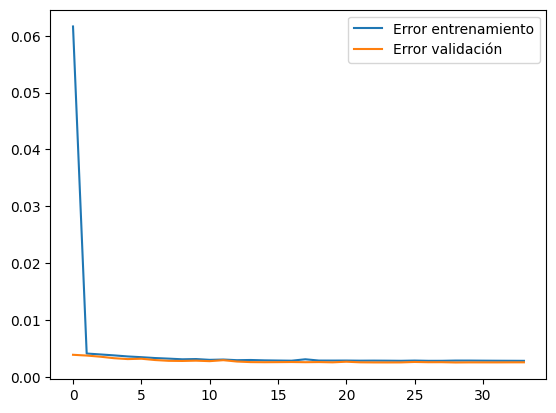

In [11]:

# Celda 10 - Visualizar la evolución del error en entrenamiento y prueba

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Error entrenamiento')
plt.plot(history.history['val_loss'], label='Error validación')
plt.legend()
plt.show()
